<center>
    <img src="../references/images/ita.png" alt="ITA" width="200">
    <h1>Curso de Excelência em Data Science</h1>
</center>  

__Autor__: [Adriano Henrique Rossette Leite](mailto:contato@adrianohrl.tech), [João Victor Freitas Machado](mailto:joao.freitas-machado@itau-unibanco.com.br), [Juliana Mayumi Suzuki ](mailto:juliana-mayumi.suzuki@itau-unibanco.com.br), [Leandro Barros Gimenez](mailto:leandro.gimenez@itau-unibanco.com.br) e [Oscar Andres Babilonia Perez](mailto:oscar.perez@itau-unibanco.com.br)

__Curso__: ITA-PEDS-CEDS851

__Disciplina__: _Machine Learning_

__Professor__: [Hitoshi Nagano](mailto:hitoshinagano@me.com)

__Tarefa__: Pevisão de Andamento dos Processos do Tribunal de Justiça do Estado de São Paulo  

__Linguagem__: Python 3.6

In [1]:
import os
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import locale
#locale.setlocale(locale.LC_ALL, 'pt')
locale.setlocale(locale.LC_ALL, 'pt_BR.utf-8')
%matplotlib inline

import nltk
#nltk.set_proxy('http://proxy.itau:8080')
#nltk.download('stopwords')
#nltk.download('rslp')
#nltk.download('punkt')

In [2]:
def count_words(x):
    return 0 if x is np.nan else len(x.split())

def get_numbers(t):
    num_dic = {'sete': 7, 
               'dez': 10, 
               'quinze': 15, 
               'cinco': 5, 
               'trinta': 30, 
               'vinte': 20, 
               'três': 3, 
               'sessenta': 60, 
               'noventa': 90}
    num = np.nan
    if re.search(r'o prazo de (.*?) dias', t) is not None:
        r = re.search(r'o prazo de (.*?) dias', t).group(1).lower()
        if len(r) < 25:
            lst = re.findall('\d+', r)
            num = num_dic.get(r) if len(lst) == 0 else max(lst)
    if str(num)[:1] == 0:
        num = int(str(num[1:]))
    return num

In [3]:
df = pd.read_pickle('../datasets/andamentos_tjsp.pkl')
df.columns = ['process', 'date', 'description', 'delta', 'action', 'seq']
df['day'] = [d.day for d in df['date']]
df['weekday'] = [d.strftime('%A') for d in df['date']]
df['month'] = [d.strftime('%B') for d in df['date']]
df['year'] = [d.year for d in df['date']]
df['characters'] = df['description'].str.len()
df['words'] = df['description'].apply(lambda x: count_words(x))
df['deadline'] = df['description'].apply(lambda x: get_numbers(x)) 
df.columns

Index(['process', 'date', 'description', 'delta', 'action', 'seq', 'day',
       'weekday', 'month', 'year', 'characters', 'words', 'deadline'],
      dtype='object')

In [4]:
processes_df = df.groupby('process', as_index = False).agg({'date': ['min', 'max'], 'seq': ['max', 'count']})
processes_df.columns = ['process', 'start_date', 'end_date', 'seq_max', 'seq_count']
processes_df['duration'] = (processes_df['end_date'] - processes_df['start_date']).dt.days / 360
processes_df['start_year'] = processes_df['start_date'].dt.year
processes_df['start_timestamp'] = processes_df['start_date'].apply(lambda x: x.timestamp())
processes_df['end_timestamp'] = processes_df['end_date'].apply(lambda x: x.timestamp())
processes_df['seq_ratio'] = processes_df['seq_count'] / processes_df['seq_max']
processes_df.describe()

,seq_max,seq_count,duration,start_year,start_timestamp,end_timestamp,seq_ratio
count,4070.000000,4070.000000,4070.000000,4070.000000,4.070000e+03,4.070000e+03,4070.000000
mean,54.204914,36.467568,1.984746,2015.223342,1.444463e+09,1.506196e+09,0.752873
std,95.241682,44.570767,2.763310,2.808021,8.911837e+07,3.255858e+07,0.156782
min,1.000000,1.000000,0.000000,1973.000000,1.064448e+08,9.791712e+08,0.014286
25%,16.000000,11.250000,0.867361,2016.000000,1.465517e+09,1.491782e+09,0.676471
50%,36.000000,26.000000,1.650000,2016.000000,1.467677e+09,1.518566e+09,0.765529
75%,63.000000,45.000000,1.927083,2016.000000,1.471824e+09,1.527466e+09,0.846154
max,3294.000000,637.000000,45.677778,2016.000000,1.479773e+09,1.529971e+09,1.000000


In [5]:
df['action'].isna().value_counts()

False    132753
True      15670
Name: action, dtype: int64

In [6]:
min_date = df['date'].min().strftime('%d/%m/%Y')
max_date = df['date'].max().strftime('%d/%m/%Y')
current_period = 'de {:s} até {:s}'.format(min_date, max_date)
print('Período vigente: {}'.format(current_period))

Período vigente: de 17/05/1973 até 26/06/2018


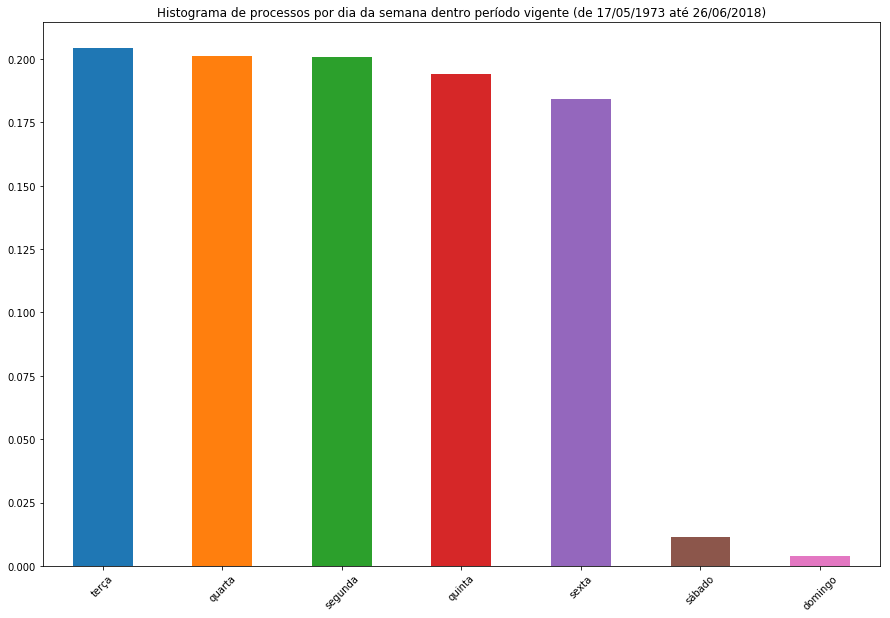

In [7]:
fig = plt.figure(figsize = (15, 10))
weekdays = ['domingo', 'segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado']
(df['weekday'].value_counts() / len(df)).plot(kind = 'bar', x = weekdays) 
plt.title('Histograma de processos por dia da semana dentro período vigente ({})'.format(current_period))
plt.xticks(rotation = 45)
plt.show()
fig.savefig("../references/images/processos_por_dia_da_semana.png", dpi = 300)

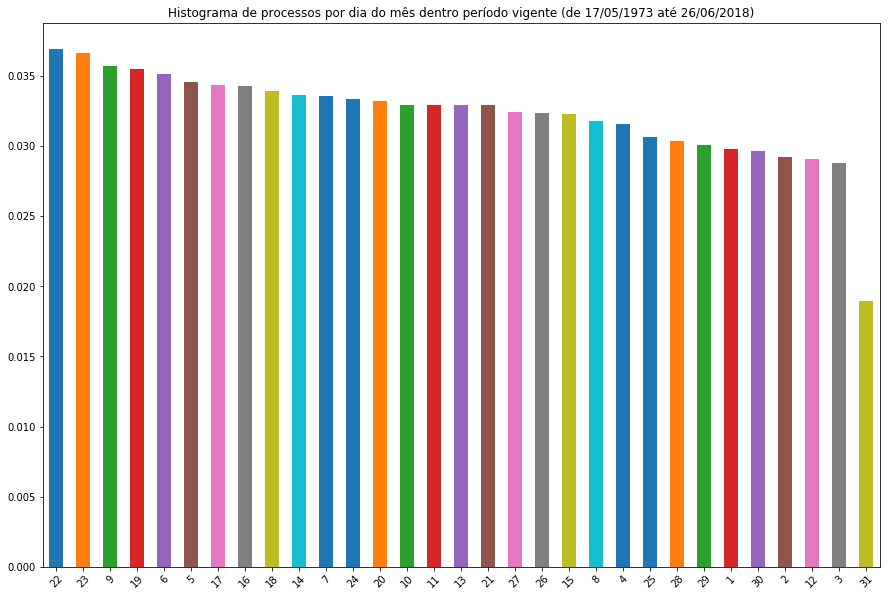

In [8]:
fig = plt.figure(figsize = (15, 10))
(df['day'].value_counts() / len(df)).plot(kind = 'bar') 
plt.title('Histograma de processos por dia do mês dentro período vigente ({})'.format(current_period))
plt.xticks(rotation = 45)
plt.show()
fig.savefig("../references/images/processos_por_dia_do_mês.png", dpi = 300)

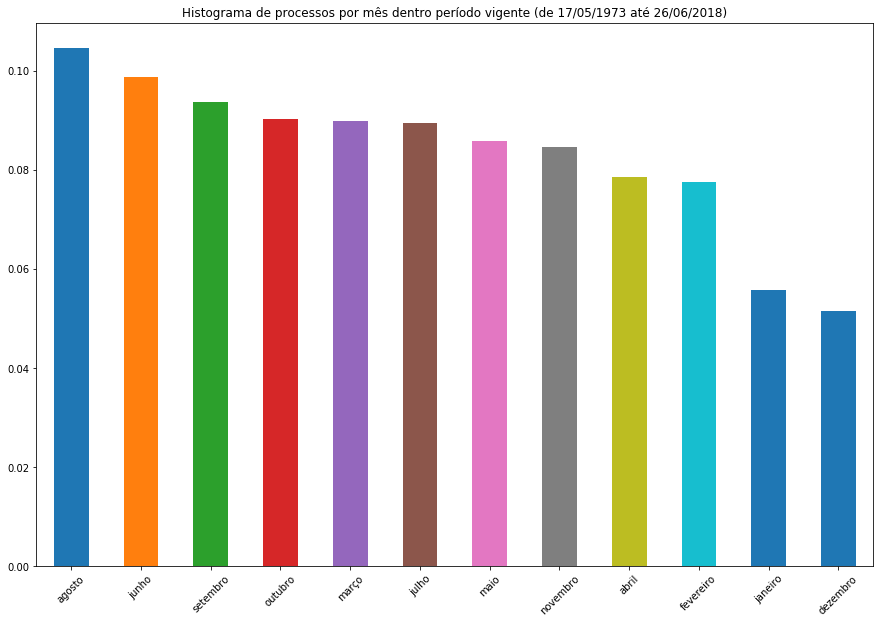

In [9]:
fig = plt.figure(figsize = (15, 10))
(df['month'].value_counts() / len(df)).plot(kind = 'bar') 
plt.title('Histograma de processos por mês dentro período vigente ({})'.format(current_period))
plt.xticks(rotation = 45)
plt.show()
fig.savefig("../references/images/processos_por_mês.png", dpi = 300)

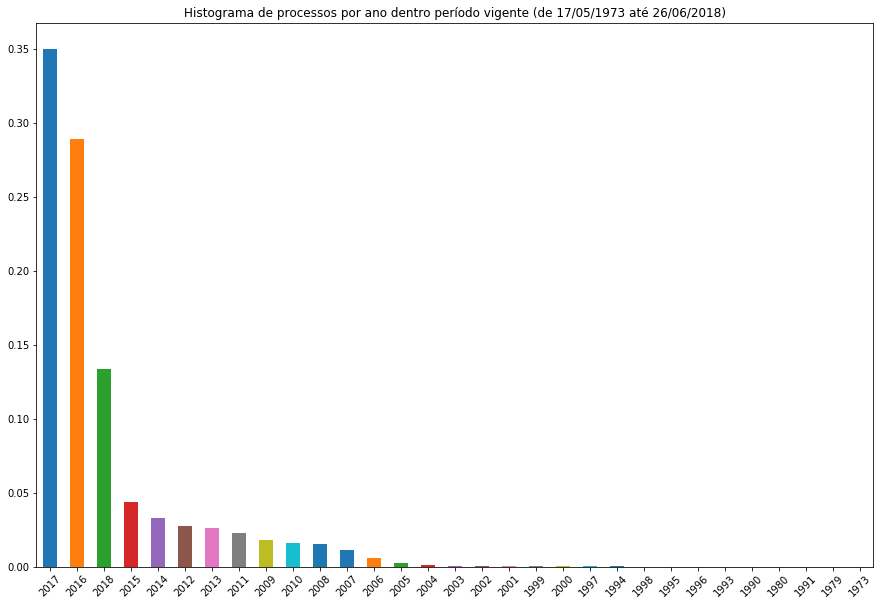

In [10]:
fig = plt.figure(figsize = (15, 10))
(df['year'].value_counts() / len(df)).plot(kind = 'bar') 
plt.title('Histograma de processos por ano dentro período vigente ({})'.format(current_period))
plt.xticks(rotation = 45)
plt.show()
fig.savefig("../references/images/processos_por_ano.png", dpi = 300)

In [11]:
colors = [(1, 0.65, 0), (0.1, 0.1, 0.44)]
cmap = LinearSegmentedColormap.from_list('itau', colors, N = 6)
wordcloud = WordCloud(background_color = 'white', colormap = cmap)

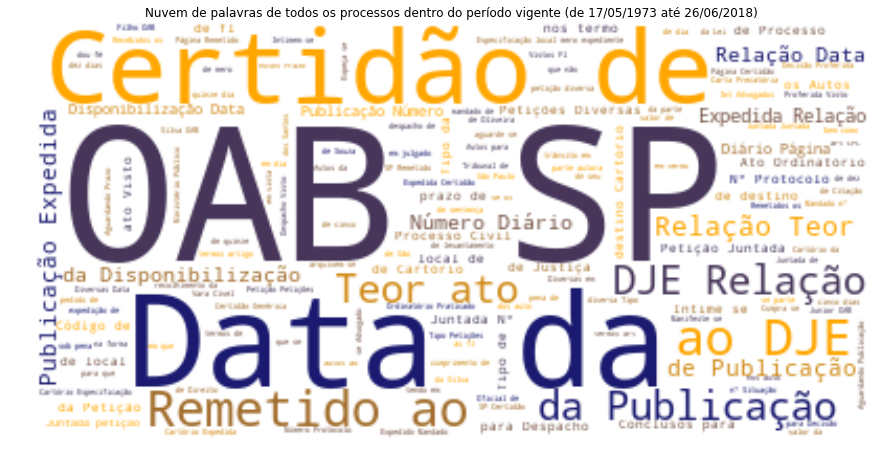

In [12]:
txt = ' '.join(df['description'])
fig = plt.figure(figsize = (15, 10))
plt.imshow(wordcloud.generate(txt), interpolation = 'bilinear')
plt.axis("off")
plt.title('Nuvem de palavras de todos os processos dentro do período vigente ({})'.format(current_period))
plt.show()
fig.savefig("../references/images/nuvem_de_palavras_dos_processos.png", dpi = 300)

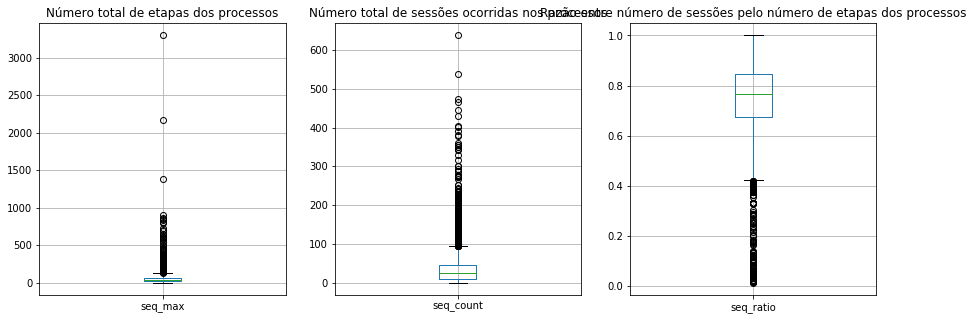

In [13]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
processes_df.boxplot(column = ['seq_max'])
plt.title('Número total de etapas dos processos')
plt.subplot(1, 3, 2)
processes_df.boxplot(column = ['seq_count'])
plt.title('Número total de sessões ocorridas nos processos')
plt.subplot(1, 3, 3)
processes_df.boxplot(column = ['seq_ratio'])
plt.title('Razão entre número de sessões pelo número de etapas dos processos')
plt.show()

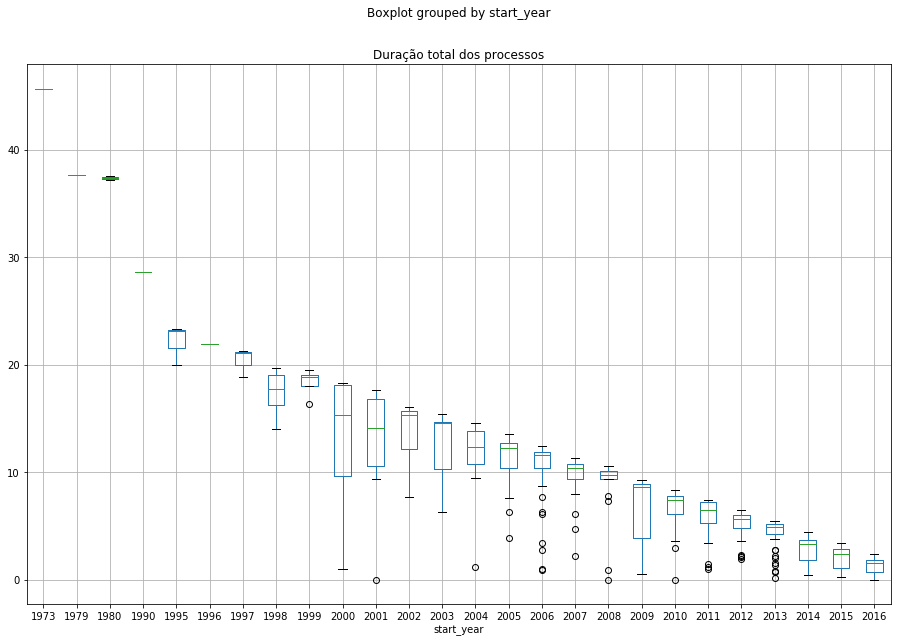

In [14]:
processes_df.boxplot(column = 'duration', by = 'start_year', figsize = (15, 10))
plt.title('Duração total dos processos')
plt.show()

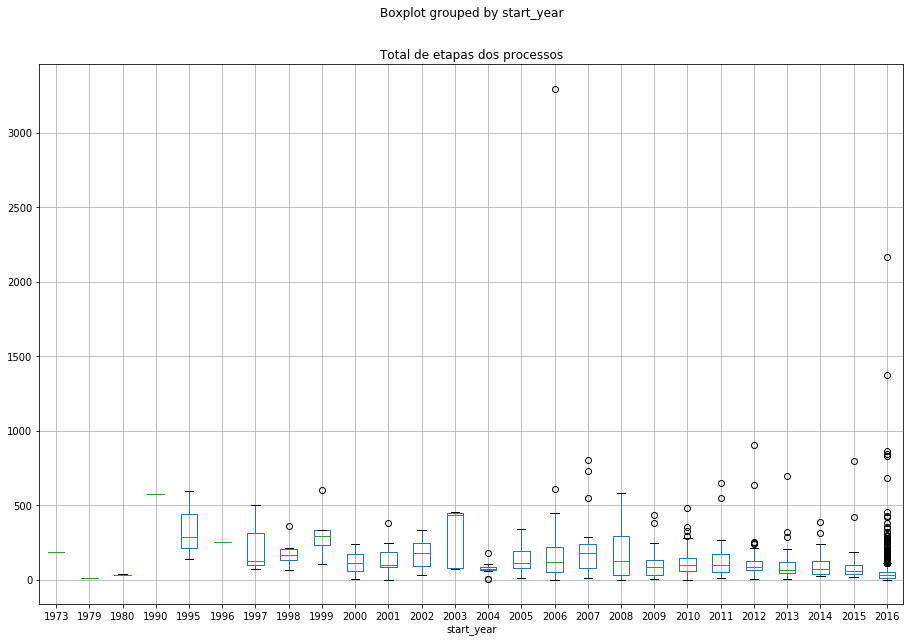

In [15]:
processes_df.boxplot(column = 'seq_max', by = 'start_year', figsize = (15, 10))
plt.title('Total de etapas dos processos')
plt.show()

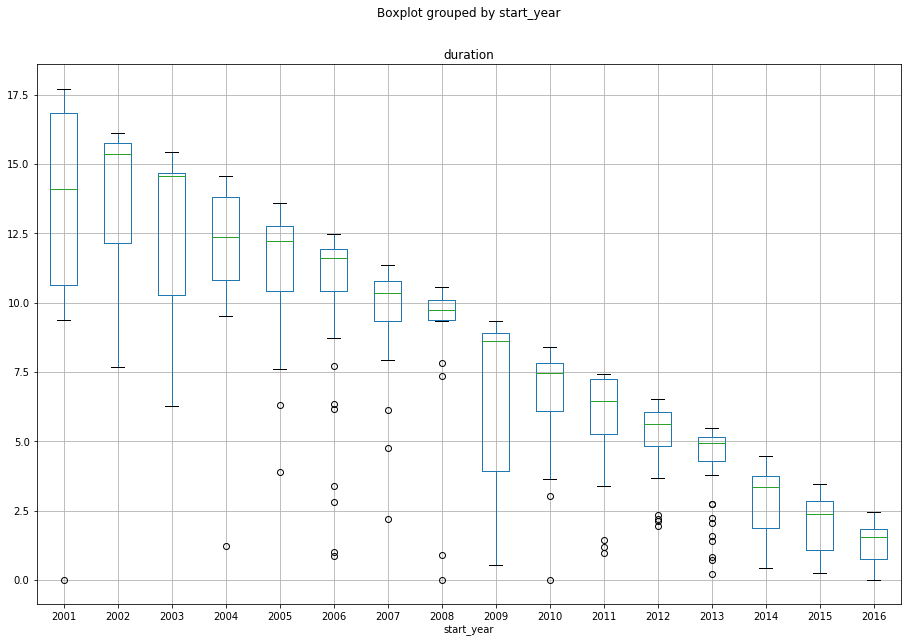

In [16]:
processes_df.loc[processes_df['start_year'] > 2000].boxplot(column = 'duration', by = 'start_year', figsize = (15, 10))

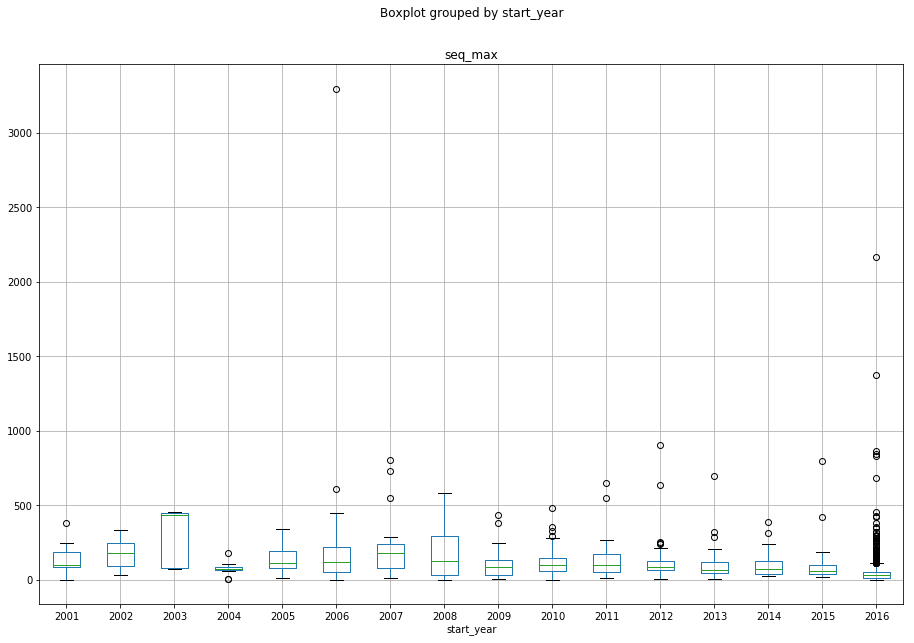

In [17]:
processes_df.loc[processes_df['start_year'] > 2000].boxplot(column = 'seq_max', by = 'start_year', figsize = (15, 10))

In [18]:
def preprocessor(txt, stop_words = nltk.corpus.stopwords.words('portuguese'), stemmer = nltk.stem.RSLPStemmer(), stem = True):
    if type(txt) != str:
        return txt
    txt = txt.lower()
    
    txt = ' '.join([word for word in txt.split() if word not in stop_words])
    if stem:
        txt = ' '.join([stemmer.stem(word) for word in txt.split()])
#     txt = re.sub(r'[ãáà]', 'a', txt)
#     txt = re.sub(r'[éê]', 'e', txt)
#     txt = re.sub(r'[í]', 'i', txt)
#     txt = re.sub(r'[õó]', 'o', txt)
#     txt = re.sub(r'[ú]', 'u', txt)
#     txt = re.sub(r'[ç]', 'c', txt)
#     #txt = re.sub(r'[\W\d]',' ', txt)
    txt = re.sub(r'\s+',' ', txt)
    return txt  

In [19]:
FILTERED_YEAR = 2015
FILTERED_DELTA = 100
df = df.loc[(df['year'] > FILTERED_YEAR) & (df['delta'] < FILTERED_DELTA), :]
df['processed_description'] = df['description'].apply(preprocessor)
df['action'] = df['action'].apply(lambda x: preprocessor(x, stem = False))
df = pd.get_dummies(df, columns = ['action', 'day', 'weekday', 'month', 'year'])
df.columns

Index(['process', 'date', 'description', 'delta', 'seq', 'characters', 'words',
       'deadline', 'processed_description', 'action_acidente trabalho',
       ...
       'month_julho', 'month_junho', 'month_maio', 'month_março',
       'month_novembro', 'month_outubro', 'month_setembro', 'year_2016',
       'year_2017', 'year_2018'],
      dtype='object', length=374)

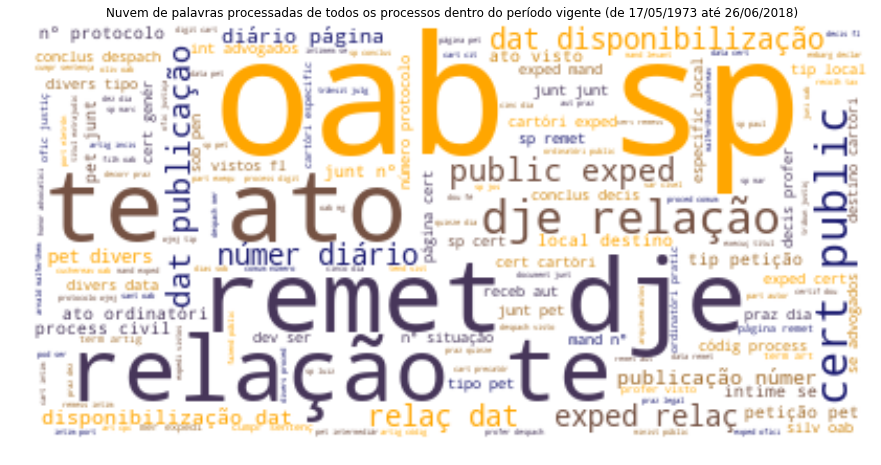

In [20]:
txt = ' '.join(df['processed_description'])
fig = plt.figure(figsize = (15, 10))
plt.imshow(wordcloud.generate(txt), interpolation = 'bilinear')
plt.axis("off")
plt.title('Nuvem de palavras processadas de todos os processos dentro do período vigente ({})'.format(current_period))
plt.show()
fig.savefig("../references/images/nuvem_de_palavras_processadas_dos_processos.png", dpi = 300)

In [21]:
DF_FILENAME = '../datasets/andamentos_tjsp_preprocessed_2015.pkl'
df.to_pickle(DF_FILENAME)

In [22]:
processes_df = df.groupby('process', as_index = False).agg({'date': ['min', 'max'], 'seq': ['max', 'count']})
processes_df.columns = ['process', 'start_date', 'end_date', 'seq_max', 'seq_count']
processes_df['duration'] = (processes_df['end_date'] - processes_df['start_date']).dt.days / 360
processes_df['start_year'] = processes_df['start_date'].dt.year
processes_df['start_timestamp'] = processes_df['start_date'].apply(lambda x: x.timestamp())
processes_df['end_timestamp'] = processes_df['end_date'].apply(lambda x: x.timestamp())
processes_df['seq_ratio'] = processes_df['seq_count'] / processes_df['seq_max']
DF_SUMMARY_FILENAME = '../datasets/andamentos_tjsp_summary_2015.pkl'
processes_df.to_pickle(DF_SUMMARY_FILENAME)